In [1]:
import numpy as np
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import random
from queue import Queue
import heapq
from itertools import permutations

class Edge:
    def __init__(self, node1, node2, weight = 0, isDirected = False):
        self.a = node1
        self.b = node2
        self.weight = weight
        self.isDirected = isDirected



    def __str__(self):
        str = str(self.a) + " -"
        if self.weight != 0:
            str += str(self.weight) + "-"
        if self.isDirected == True:
            str += ">"
        str += " " + str(self.b)
        return str



    def reverseEdge(self):
        self.a, self.b = self.b, self.a

class MyGraph:
    #1 - Adjacency List
    #2 - Adjacency Matrix
    #3 - Incidence Matrix
    #class constructor which uses one of 3 representations and fills the others
    #type1 - which type of representation is being used to create a Graph class
    def __init__(self, graph = [], type1 = 1):
        self.graph = {}
        self.weightMatrix = np.zeros((1,1))
        match type1:
            case 1:
                self.adjacencyList = graph
                self.adjacencyMatrix = MyGraph.changeRepresentation(graph, 1, 2)
                self.incidenceMatrix = MyGraph.changeRepresentation(graph, 1, 3)
            case 2:
                self.adjacencyMatrix = graph
                self.adjacencyList = MyGraph.changeRepresentation(graph, 2, 1)
                self.incidenceMatrix = MyGraph.changeRepresentation(graph, 2, 3)
            case 3:
                self.incidenceMatrix = graph
                self.adjacencyList = MyGraph.changeRepresentation(graph, 3, 1)
                self.adjacencyMatrix = MyGraph.changeRepresentation(graph, 3, 2)



    def getWeight(self, a, b):
        return self.weightMatrix(a, b)


    def getWeightMatrix(self):
        return self.weightMatrix

    def createAdjacencyMatrixFromAdjacencyList(graph):
        numberOfNodes = len(graph)
        adjacencyMatrix = np.zeros((numberOfNodes, numberOfNodes))
        for i in range(numberOfNodes):
            for j in graph[i]:
                adjacencyMatrix[i][j] = 1
                adjacencyMatrix[j][i] = 1
        return adjacencyMatrix



    def createIncidenceMatrixFromAdjacencyList(graph):
        numberOfNodes = len(graph)
        numberOfEdges = int(sum([len(i) for i in graph]) / 2)
        incidenceMatrix = np.zeros((numberOfNodes, numberOfEdges))
        edgeIndex = 0
        for i in range(numberOfNodes):
            for j in graph[i]:
                if(i < j):
                    incidenceMatrix[i][edgeIndex] = 1
                    incidenceMatrix[j][edgeIndex] = 1
                    edgeIndex += 1
        return incidenceMatrix



    def createAdjacencyListFromAdjacencyMatrix(matrix):
        numberOfNodes = len(matrix)
        adjacencyList = []
        for i in range(numberOfNodes):
            temp = []
            for j in range(numberOfNodes):
                if(matrix[i][j] == 1):
                    temp.append(j)
            adjacencyList.append(temp)
        return adjacencyList



    def createAdjacencyListFromIncidenceMatrix(matrix):
        numberOfNodes = len(matrix)
        adjacencyList = []
        for i in range(numberOfNodes):
            adjacencyList.append([])
        temp = []
        for j in range(len(matrix[0])):
            temp1 = []
            for i in range(numberOfNodes):
                if(matrix[i][j] == 1):
                    temp1.append(i)
            temp.append(temp1)

        for i in temp:
            if(len(i) != 2):
                print("Incorrect Incidence Matrix:",i)
            try:
                adjacencyList[i[0]].append(i[1])
                adjacencyList[i[1]].append(i[0])
            except:
                pass
        return adjacencyList

    def syncWeightMatrixWithIncidenceMatrix(self, w_matrix):
        self.weightMatrix = w_matrix
        self.incidenceMatrix = np.zeros((len(w_matrix), len(w_matrix[0])))
        for i in range(len(w_matrix)):
            for j in range(len(w_matrix[i])):
                if w_matrix[i][j] > 0:
                    self.incidenceMatrix[i][j] = 1
        self.synchronizeRepresentations(3)

    #changes one graph representation to another
    def changeRepresentation(graph1, type1, type2):
        numberOfNodes = len(graph1)
        match type1:
            case 1:
                match type2:
                    case 2:
                        return MyGraph.createAdjacencyMatrixFromAdjacencyList(graph1)
                    case 3:
                        return MyGraph.createIncidenceMatrixFromAdjacencyList(graph1)
            case 2:
                graph = MyGraph.createAdjacencyListFromAdjacencyMatrix(graph1)
                match type2:
                    case 1:
                        return graph
                    case 3:
                        return MyGraph.createIncidenceMatrixFromAdjacencyList(graph)
            case 3:
                graph = MyGraph.createAdjacencyListFromIncidenceMatrix(graph1)
                match type2:
                    case 1:
                        return graph
                    case 2:
                        #we just use the same algorithm as in case 1-2
                        return MyGraph.createAdjacencyMatrixFromAdjacencyList(graph)


    #check if first and last vertex are connected ( and all others)
    def is_hamiltonian_cycle(self, path):
        if path[0] not in self.adjacencyList[path[-1]]:
            return False

        for i in range(len(path) - 1):
            if path[i + 1] not in self.adjacencyList[path[i]]:
                return False
        return True


    # If the path includes all vertices and returns to the start, it's a cycle
    def find_hamiltonian_cycle_util(self, path, visited):
        if len(path) == len(self.adjacencyList) and self.is_hamiltonian_cycle(path):
            return path + [path[0]]

        for vertex in self.adjacencyList[path[-1]]:
            if not visited[vertex]:
                visited[vertex] = True
                path.append(vertex)

                cycle = self.find_hamiltonian_cycle_util(path, visited)
                if cycle:
                    return cycle

                visited[vertex] = False
                path.pop()

        return None

    #if there is a hamiltonian cycle in the graph, it returns the cycle, otherwise it returns None
    def find_hamiltonian_cycle(self):
        n = len(self.adjacencyList)
        for start_vertex in range(n):
            path = [start_vertex]
            visited = [False] * n
            visited[start_vertex] = True

            cycle = self.find_hamiltonian_cycle_util(path, visited)
            if cycle:
                return cycle

        return None

    #djikstra algorithm
    def dijkstra(self, src):
        import sys
        num_vertices = len(self.adjacencyList)
        dist = [sys.maxsize] * num_vertices
        dist[src] = 0
        prev = [None] * num_vertices
        pq = [(0, src)]
        visited = set()

        while pq:
            current_distance, u = heapq.heappop(pq)
            if u in visited:
                continue
            visited.add(u)

            for v in self.adjacencyList[u]:
                weight = self.weightMatrix[u][v]
                if v not in visited and dist[v] > dist[u] + weight:
                    dist[v] = dist[u] + weight
                    prev[v] = u
                    heapq.heappush(pq, (dist[v], v))


        paths = []
        for vertex in range(num_vertices):
            path = []
            step = vertex
            if dist[step] != sys.maxsize:
                while step is not None:
                    path.append(step)
                    step = prev[step]
                path.reverse()
            paths.append((vertex, path, dist[vertex]))
        return paths


    #returns all pairs of shortest paths
    def all_pairs_shortest_path(self, n):
        distance_matrix = []
        for src in range(n):
            distance_matrix.append(self.dijkstra(src))
        return distance_matrix


    #Adds point ONLY TO adjacencyList
    def addNode(self):
        self.adjacencyList.append([])
        self.weightMatrix.resize((len(self.weightMatrix) + 1,len(self.weightMatrix) + 1))



    #Adds directedEdge ONLY TO adjacencyList
    def addDirectedEdge(self, edge):
        self.adjacencyList[edge.a].append(edge.b)
        self.weightMatrix[edge.a,edge.b] = edge.weight



    #Adds edge ONLY TO adjacencyList
    def addEdge(self,edge):
        self.addDirectedEdge(edge)

        if not edge.isDirected:
            edge.reverseEdge()
            self.addDirectedEdge(edge)
            edge.reverseEdge()



    #Deletes derectedEdge ONLY FROM adjacencyList
    def removeDirectedEdge(self, edge):
        self.adjacencyList[edge.a].remove(edge.b)
        self.weightMatrix[edge.a,edge.b] = 0



    #Deletes edge ONLY FROM adjacencyList
    def removeEdge(self, edge):
        self.removeDirectedEdge(edge)

        if not edge.isDirected:
            edge.reverseEdge()
            self.removeDirectedEdge(edge)
            edge.reverseEdge()



    def synchronizeRepresentations(self, correctRepresentation):
        match correctRepresentation:
            case 1:
                self.adjacencyMatrix = MyGraph.changeRepresentation(self.adjacencyList, 1, 2)
                self.incidenceMatrix = MyGraph.changeRepresentation(self.adjacencyList, 1, 3)
            case 2:
                self.adjacencyList = MyGraph.changeRepresentation(self.adjacencyMatrix, 2, 1)
                self.incidenceMatrix = MyGraph.changeRepresentation(self.adjacencyMatrix, 2, 3)
            case 3:
                self.adjacencyList = MyGraph.changeRepresentation(self.incidenceMatrix, 3, 1)
                self.adjacencyMatrix = MyGraph.changeRepresentation(self.incidenceMatrix, 3, 2)



    #Generates random graph with n nodes and l edges
    def getRandomGraphNL(n,l):
        #generate all passible edges
        possible_edges = []
        for i in range(n):
            for j in range(i+1,n):
                possible_edges.append(Edge(i,j))
        #get l edges for array
        edges = random.sample(possible_edges, l)
        #Create graph by adding n nodes and l edges
        G = MyGraph([],1)
        for i in range(n):
            G.addNode()
        for edge in edges:
            G.addEdge(edge)
        #Add othrer representations to the graph
        G.synchronizeRepresentations(1)
        return G



    def fillWeightMatrix(self):
        visited = np.zeros(len(self.adjacencyList))
        q = Queue()
        color = 0
        index = 0
        while True:
            index1 = np.where(visited == 0)
            if len(index1[0]) == 0:
                break
            index = index1[0][0]
            q.put(index)
            visited[index] = 1
            while not q.empty():
                node = q.get()
                for i in self.adjacencyList[node]:
                    if self.weightMatrix[node][i] == 0:
                        q.put(i)
                        visited[i] = 1
                        weight = random.randint(1, 10)
                        self.weightMatrix[node][i] = weight
                        if node in self.adjacencyList[i]:
                            self.weightMatrix[i][node] = weight



    def getRandomConnectedGraph(n, l):
        graph = MyGraph.getRandomGraphNL(n,l)
        isGood = False
        temp = 0
        while True:
            for i in graph.adjacencyList:
                if i != []:
                    temp += 1
            if temp == len(graph.adjacencyList):
                break
            graph = MyGraph.getRandomGraphNL(n,l)
            temp = 0
        if(l < n - 1):
            print("Naucz sie liczyć krawędzie!\nNie stworzysz z tego spójnego grafu.")
            return graph
        while graph.isGraphConnected() == False:
            graph.randomizeGraph(1)
        graph.synchronizeRepresentations(1)
        return graph

    def getRandomConnectedWeightedGraph(n, l):
        graph = MyGraph.getRandomConnectedGraph(n, l)
        graph.fillWeightMatrix()
        return graph

    @staticmethod
    def getRandomConnectedWeightedGraph(n, l):
        graph = MyGraph.getRandomConnectedGraph(n, l)
        graph.fillWeightMatrix()
        return graph


    #Generates random graph with n nodes and p is propability of each edge beeing present
    def getRandomGraphNP(n,p):
        #iterate over all possible edges and add them to edge table if rondom int is bigger than propability
        edges = []
        for i in range(n):
            for j in range(i+1,n):
                random_float = random.random()
                if p>=random_float:
                    edges.append(Edge(i,j))
        #Create graph by adding n nodes and l edges
        G = MyGraph([],1)
        for i in range(n):
            G.addNode()
        for edge in edges:
            G.addEdge(edge)
        #Add other representations to the graph
        G.synchronizeRepresentations(1)
        return G



    #Draws graph
    def showGraph(self, filename = None):
        #get edges from adjacencyList
        edges = []
        for i in range(len(self.adjacencyList)):
            for j in self.adjacencyList[i]:
                if(i < j):
                    edges.append(Edge(i,j))
        #construct networkx graph
        G = nx.Graph()
        for i in range(len(self.adjacencyList)):
            G.add_node(i)
        for i in range(len(self.adjacencyList)):
            for neighbor in self.adjacencyList[i]:
                G.add_edge(i, neighbor)
        #set layout and draw graph with specified parameters
        pos = nx.circular_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)
        if filename != None:
            plt.savefig(filename)
            plt.close()
        else:
            plt.show()

    def showWeightedGraph(self, filename = None):
        #get edges from adjacencyList
        edges = []
        for i in range(len(self.adjacencyList)):
            for j in self.adjacencyList[i]:
                if(i < j):
                    edges.append(Edge(i,j))
        #construct networkx graph
        G = nx.Graph()
        for i in range(len(self.adjacencyList)):
            G.add_node(i)
        for i in range(len(self.adjacencyList)):
            for neighbor in self.adjacencyList[i]:
                G.add_edge(i, neighbor, weight = self.weightMatrix[i][neighbor])
        #set layout and draw graph with specified parameters
        pos = nx.circular_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        if filename != None:
            plt.savefig(filename)
            plt.close()
        else:
            plt.show()



    def __str__(self):
        return f"Adjacency List:\n{self.adjacencyList}\n\nAdjacency Matrix:\n{self.adjacencyMatrix}\n\nIncidence Matrix:\n{self.incidenceMatrix}\n"

    #Constructs graph from graphical sequence and returns adjacency list
    def constructGraphFromGraphical(sequence):
        n = len(sequence)
        adjacency_list = [[] for _ in range(n)]
        active_nodes = list(range(n))  # list of active nodes
        degrees = [0] * n  # list of degrees of nodes
        start_sequence = sequence.copy()
        check_start = 0
        while sequence:
            sequence = sorted(sequence, reverse=True)
            print()
            print("Active nodes:")
            print(active_nodes)
            print("Sequence:")
            print(sequence)
            print("Degrees:")
            print(degrees)
            if sequence[0] == 0:
                break
            while degrees[0] >= start_sequence[check_start]:
                active_nodes.pop(0)
                degrees.pop(0)
                check_start += 1
            for i in range(1, sequence[0] + 1):
                # Find a node that has room for another connection
                for j in range(i, len(active_nodes)):
                    if degrees[j] < start_sequence[j+check_start]:
                        sequence[j] -= 1
                        degrees[j] += 1
                        degrees[0] += 1
                        adjacency_list[active_nodes[0]].append(active_nodes[j])
                        adjacency_list[active_nodes[j]].append(active_nodes[0])
                        break
                else:
                    return None  # Return None if no node has room for another connection
            sequence[0] = 0
            active_nodes.pop(0)  # remove the node from the active list
            degrees.pop(0)  # remove the degree of the processed node
            check_start += 1
        return adjacency_list

    #Checks if sequence is graphical
    def isGraphicSequence(A):
        n = len(A)
        while True:
            A = sorted(A, reverse=True)
            if all(a == 0 for a in A):
                return True
            if A[0] >= n or any(a < 0 for a in A):
                return False
            for i in range(1, A[0] + 1):
                A[i] -= 1
            A[0] = 0



    def swapNodesInEdges(edge1, edge2):
        newEdge1 = (edge1.a, edge2.b)
        newEdge2 = (edge1.b, edge2.a)
        return newEdge1, newEdge2



    #Randomizes graph by swapping edges
    def randomizeGraph(self, num_iterations):
        for _ in range(num_iterations):
            edges = [(i, j) for i, neighbors in enumerate(self.adjacencyList) for j in neighbors if i < j]
            for _ in range(100):
                first_edge = random.choice(edges)
                second_edge = random.choice(edges)
                if first_edge == second_edge or first_edge[0] == second_edge[1] or first_edge[1] == second_edge[0]:
                    continue
                new_edge1 = (first_edge[0], second_edge[1])
                new_edge2 = (first_edge[1], second_edge[0])
                if new_edge1 in edges or new_edge2 in edges:
                    continue
                break
            self.adjacencyList[first_edge[0]].remove(first_edge[1])
            self.adjacencyList[first_edge[1]].remove(first_edge[0])
            self.adjacencyList[second_edge[0]].remove(second_edge[1])
            self.adjacencyList[second_edge[1]].remove(second_edge[0])
            self.adjacencyList[first_edge[0]].append(second_edge[1])
            self.adjacencyList[second_edge[1]].append(first_edge[0])
            self.adjacencyList[first_edge[1]].append(second_edge[0])
            self.adjacencyList[second_edge[0]].append(first_edge[1])
        self.synchronizeRepresentations(1)


    def divideGraphIntoConnectedComponents(self):
        colored = np.zeros(len(self.adjacencyList))
        q = Queue()
        color = 0
        index = 0
        while(True):
            color += 1
            #find next unvisited node
            index1 = np.where(colored == 0)
            if len(index1[0]) == 0:
                break
            index = index1[0][0]
            #add to queue
            q.put(index)
            colored[index] = color
            while not q.empty():
                node = q.get()
                #add to queue all his neighbours
                for i in self.adjacencyList[node]:
                    if colored[i] == 0:
                        q.put(i)
                        colored[i] = color
        return colored



    def findBiggestConnectedComponent(self):
        colored = self.divideGraphIntoConnectedComponents()
        res = np.count_nonzero(colored == 0)
        index = 0
        while res > 0:
            index += 1
            res = np.count_nonzero(colored == index)
        return  colored, index - 1


    def isGraphConnected(self):
        colored = self.divideGraphIntoConnectedComponents()
        firstColor = colored[0]
        for i in colored:
            if i != firstColor:
                return False
        return True


    def generateKRegularGraph(n, k): # n - number of vertices, k - degree
        if n <= k:
            raise Exception("n must be greater than k")
        if k * n % 2 != 0:
            raise Exception("k * n must be even")


        # degree sequence
        degreeSequence = [[i, k] for i in range(n)] # i - vertex, k - degree of vertex
        adjList = [[] for i in degreeSequence]
        # print(degreeSequence)


        while True:
            # check if all degrees in degreeSequence are equal to k
            if all(i[1] == 0 for i in degreeSequence):
                break
            for i in range(1, degreeSequence[0][1] + 1):
                degreeSequence[i][1] -= 1
                # add an edge between vertices a and b
                a = degreeSequence[0][0]
                b = degreeSequence[i][0]
                adjList[a].append(b)
                adjList[b].append(a)

            degreeSequence[0][1] = 0
            degreeSequence.sort(reverse=True, key=lambda x: x[1])
        g = MyGraph(adjList, 1)
        # g.randomizeGraph(1)
        return g


if __name__ == "__main__":
    #Example of usage
    G = MyGraph()
    B = MyGraph.getRandomConnectedWeightedGraph(5, 4)
    B.showGraph('graph.png')

Lab2 zad 6

Znaleziono cykl hamiltonowski: [0, 1, 5, 2, 4, 3, 0]


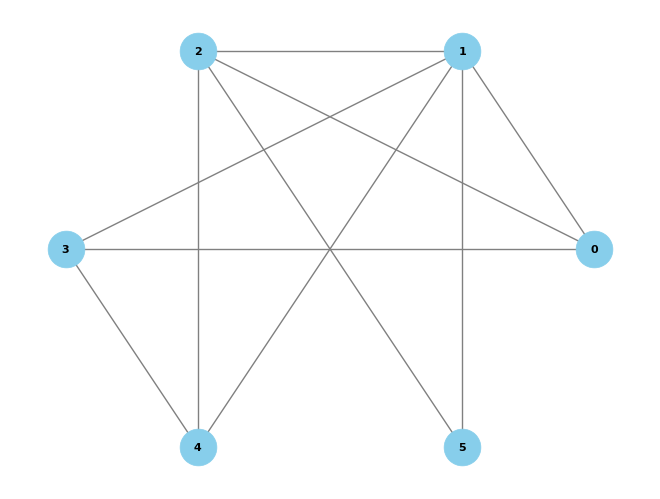

In [2]:
G = MyGraph.getRandomGraphNP(6, 0.7)


cycle = MyGraph.find_hamiltonian_cycle(G)

if cycle:
    print("Znaleziono cykl hamiltonowski:", cycle)
else:
    print("Graf nie jest hamiltonowski.")

G.showGraph()

Lab3 zad 2, 3

Do wierzchołka 0: Ścieżka [0], Długość:  0
Do wierzchołka 1: Ścieżka [0, 4, 1], Długość:  16
Do wierzchołka 2: Ścieżka [0, 2], Długość:  6
Do wierzchołka 3: Ścieżka [0, 4, 3], Długość:  12
Do wierzchołka 4: Ścieżka [0, 4], Długość:  7
Do wierzchołka 5: Ścieżka [0, 4, 5], Długość:  15

0	 16.0	 6.0	 12.0	 7.0	 15.0	 
16.0	 0	 17.0	 4.0	 9.0	 17.0	 
6.0	 17.0	 0	 13.0	 8.0	 16.0	 
12.0	 4.0	 13.0	 0	 5.0	 13.0	 
7.0	 9.0	 8.0	 5.0	 0	 8.0	 
15.0	 17.0	 16.0	 13.0	 8.0	 0	 


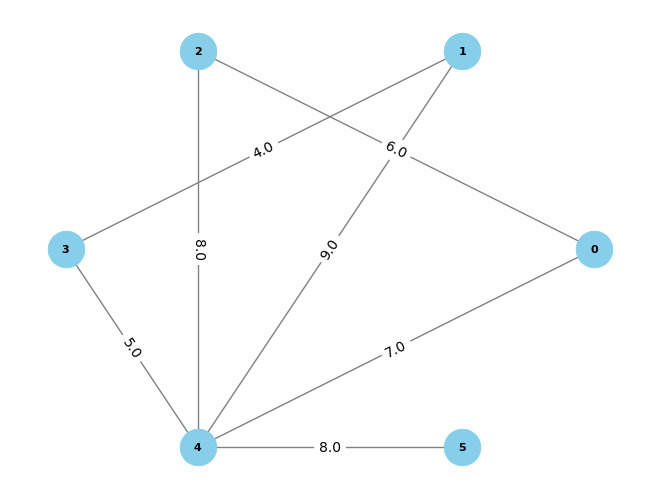

In [3]:
n=6
graph = MyGraph.getRandomConnectedWeightedGraph(n, 7)

paths = MyGraph.dijkstra(graph, 0)

for target, path, length in paths:
    print(f"Do wierzchołka {target}: Ścieżka {path}, Długość:  {int(length)}")
print()

distance_matrix = graph.all_pairs_shortest_path(n)
for row in distance_matrix:
    for element in row:
        print(f"{element[2]}\t", end=" ")
    print()
graph.showWeightedGraph()



